# Spatial Target Cells

Analyses for if cells care about the spatial target.

Cells of interest:
- 74 looks to be a serial position cell

In [1]:
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from collections import Counter

import numpy as np
from scipy.stats import sem
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

from spiketools.spatial.occupancy import compute_spatial_bin_edges, compute_spatial_bin_assignment
from spiketools.spatial.information import _compute_spatial_information
from spiketools.stats.shuffle import shuffle_spikes
from spiketools.stats.permutations import zscore_to_surrogates, compute_empirical_pvalue
from spiketools.plts.space import plot_heatmap
from spiketools.plts.stats import plot_surrogates
from spiketools.plts.utils import make_axes
from spiketools.utils import restrict_range
from spiketools.utils.data import get_value_by_time, get_value_by_time_range

In [3]:
import seaborn as sns
sns.set_context('talk')

In [4]:
import sys
sys.path.append('../code')
from analysis import get_spike_positions, compute_bin_firing
from target import compute_serial_position_fr, compute_spatial_target_bins

## Settings

In [5]:
# Set which task to analyze
task = 'THF'

In [6]:
# Define the base data folder
data_folder = Path('/Users/tom/Documents/Data/JacobsLab/TH/' + task)

In [7]:
# Define subject information
subj = 'wv001'
session = 2

In [8]:
# Define binning for chests (spatial target)
chest_bins = [5, 7]

In [9]:
# Shuffle Settings
shuffle_approach = 'BINCIRC'
n_surrogates = 100

## Load Data

In [10]:
# Define expected NWB file name & full path
file_name = '_'.join([subj, 'session_' + str(session)]) + '.nwb'
full_path = data_folder / 'NWB' / file_name

In [11]:
# Load NWB file
io = NWBHDF5IO(str(full_path), 'r')
nwbfile = io.read()

In [12]:
# Get the number of trials & units
n_trials = len(nwbfile.trials)
n_units = len(nwbfile.units)

In [13]:
# Get spikes
uind = 0
spikes = nwbfile.units.get_unit_spike_times(uind)
spikes = spikes / 1000

In [14]:
# Drop spikes until task time
st = nwbfile.trials['start_time'][0]
en = nwbfile.trials['stop_time'][-1]
spikes = restrict_range(spikes, st, en)

In [15]:
# Extract behavioural markers of interest
trial_starts = nwbfile.trials['start_time'].data[:]
#chest_openings = nwbfile.trials.chest_opening.data[:]
chest_openings = nwbfile.trials.to_dataframe()['chest_opening'].values

In [16]:
# Extract the position data
pos = nwbfile.acquisition['position']['xy_position']
ptimes = pos.timestamps[:]
positions = pos.data[:]

In [17]:
# Get the chest positions & trial indices
chest_xs, chest_ys  = nwbfile.acquisition['chest_positions']['chest_positions'].data[:]
chest_trials = nwbfile.acquisition['chest_trials']['chest_trials'].data[:]

## Chest Positions

In [18]:
# Check chest position range
print('Chest X position range: {:1.2f} - {:1.2f}'.format(np.min(chest_xs), np.max(chest_xs)))
print('Chest Y position range: {:1.2f} - {:1.2f}'.format(np.min(chest_ys), np.max(chest_ys)))

Chest X position range: 362.86 - 406.85
Chest Y position range: 321.34 - 396.47


In [19]:
# Check traversal position range
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[0, :]), np.max(positions[0, :])))
print('Position X range: {:1.2f} - {:1.2f}'.format(np.min(positions[1, :]), np.max(positions[1, :])))

Position X range: 365.40 - 404.59
Position X range: 285.00 - 433.00


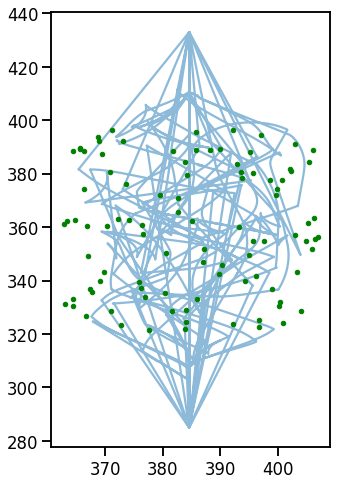

In [20]:
# Plot the subject positions, overlaid with chest positions
#   Note: update this to use plot_positions
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*positions, alpha=0.5)
ax.plot(chest_xs, chest_ys, '.g');

In [21]:
# Compute edges for chest binning
area_range = [[360, 410], [320, 400]]
x_edges, y_edges = compute_spatial_bin_edges(positions, chest_bins, area_range=area_range)

In [22]:
# Assign each chest to a bin
chest_pos = np.array([chest_xs, chest_ys])
ch_xbin, ch_ybin = compute_spatial_bin_assignment(chest_pos, x_edges, y_edges)

# Fix offset of chest binning
ch_xbin = ch_xbin - 1 
ch_ybin = ch_ybin - 1 

## Single Trial

In [23]:
# Get trial information
t_ind = 10
t_st = nwbfile.trials['start_time'][t_ind]
ch_openings = nwbfile.trials['chest_opening'][t_ind]
t_en = ch_openings[-1]

In [24]:
# Get the chests for the current trial
t_mask = chest_trials == t_ind

In [25]:
# Select chest openings for the current trial
t_time, t_pos = get_value_by_time_range(ptimes, positions, t_st, t_en)
ch_times = [get_value_by_time(t_time, t_pos, ch_op) for ch_op in ch_openings]

In [26]:
# Restrict spikes to the 
t_spikes = restrict_range(spikes, t_st, t_en)
t_spike_xs, t_spike_ys = get_spike_positions(t_spikes, t_time, t_pos)

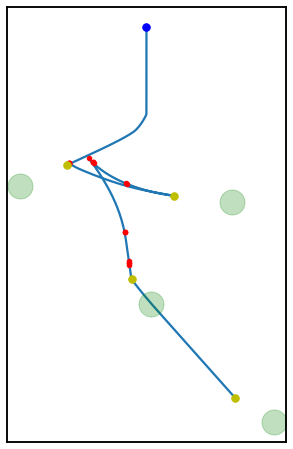

In [27]:
# Plot an encoding trial: with traversals, chest locations, and spike firing
# TODO: add stimulus and event happenings to `plot_positions` & use that here
_, ax = plt.subplots(figsize=(5, 8))
ax.plot(*t_pos)
ax.plot(*t_pos[:, 0], 'b.', ms=15)
ax.plot(t_spike_xs, t_spike_ys, '.r')
[ax.plot(*cht, 'y.', ms=15) for cht in ch_times];
ax.plot(chest_xs[t_mask], chest_ys[t_mask], '.g', ms=50, alpha=0.25)
ax.set_xticklabels([]); ax.set_yticklabels([]);
ax.xaxis.set_ticks_position('none')
ax.yaxis.set_ticks_position('none')

## Serial Position

In [28]:
# Get the length of time between segments (chest openings)
seg_times = np.diff(np.insert(ch_openings, 0, t_time[0]))

In [29]:
# Count firing in each segment, and compute firing rate
count = Counter({0 : 0, 1 : 0, 2 : 0, 3 : 0})
count.update(np.digitize(t_spikes, ch_openings))
inds = count.keys()
frs = np.array(list(count.values())) / seg_times * 1000

<BarContainer object of 4 artists>

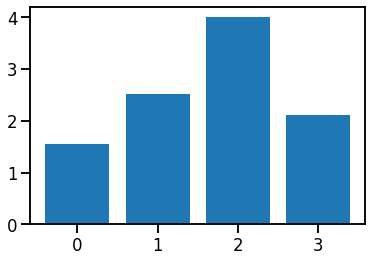

In [30]:
# Plot firing rate per segment (single trial)
plt.bar(inds, frs)

In [31]:
# Compute firing rates per segment across all trials
all_frs = compute_serial_position_fr(spikes, trial_starts, chest_openings, chest_trials, ptimes, positions)

<BarContainer object of 4 artists>

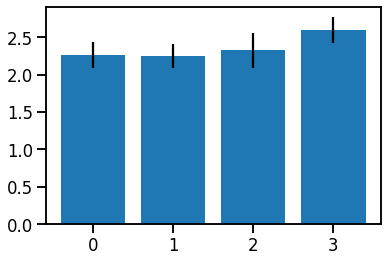

In [32]:
# Plot firing rates per segment across all trials
plt.bar(inds, all_frs.mean(0), yerr=sem(all_frs, 0))

## Spatial Target Bins

In [33]:
# Compute chest occupancy
chest_occupancy = compute_bin_firing(ch_xbin, ch_ybin, chest_bins)

In [34]:
# Check the number of chests per bin
print("Range of chests per bin: {:1.0f} - {:1.0f}".format(\
    np.min(chest_occupancy), np.max(chest_occupancy)))

Range of chests per bin: 0 - 6


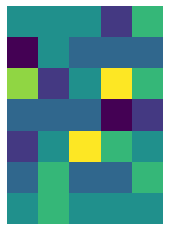

In [35]:
# Plot chest occupancy
plot_heatmap(chest_occupancy, transpose=True)

In [36]:
# Collect firing per chest location across all trials
target_bins = compute_spatial_target_bins(spikes, trial_starts, chest_openings, chest_trials, 
                                          ptimes, positions, chest_bins, ch_xbin, ch_ybin)

In [37]:
# Check range of firing across spatial target bins
np.min(target_bins), np.max(target_bins)

(0.0, 4.142743853590478)

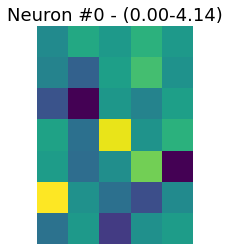

In [38]:
# Check the firing rate per spatial destination for an example neuron
plot_heatmap(target_bins, transpose=True,
             title='Neuron #{} - ({:1.2f}-{:1.2f})'.format(uind, np.min(target_bins), np.max(target_bins)))

#### Spatial Information

In [39]:
# Compute spatial information for the target firing
spike_info = _compute_spatial_information(target_bins, chest_occupancy)
print(spike_info)

0.24662650398405545


In [40]:
# Create shuffled time series for comparison
#   Note: some temporary quirks here to deal with UNIX time
temp = spikes - st
times_shuffle = shuffle_spikes(temp, shuffle_approach, n_surrogates)
times_shuffle = times_shuffle + st

In [41]:
# Compute spatial information measures on surrogates
surrs = np.zeros(n_surrogates)
for ind, stimes in enumerate(times_shuffle):
    
    target_bins = compute_spatial_target_bins(stimes, trial_starts, chest_openings, chest_trials, 
                                              ptimes, positions, chest_bins, ch_xbin, ch_ybin)         
    surrs[ind] = _compute_spatial_information(target_bins, chest_occupancy)

In [42]:
# Compute the empirical p-value based on surrogates
surr_p_val = compute_empirical_pvalue(spike_info, surrs)

# Compute z-score of spatial information compared to surrogates
z_score = zscore_to_surrogates(spike_info, surrs)

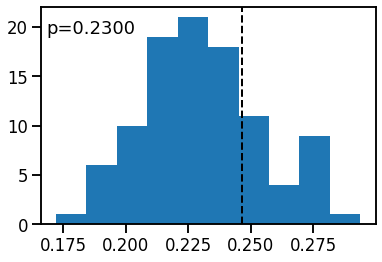

In [43]:
# Plot distribution of surrogates with measured empirical value
plot_surrogates(surrs, spike_info, surr_p_val)

## All Cells

In [44]:
# # Plot spatial target heat maps for all cells
# for ii, ax in zip(range(n_units), make_axes(n_units, hspace=0.4)):
    
#     spikes = nwbfile.units.get_unit_spike_times(ii) / 1000
#     spikes = restrict_range(spikes, st, en)

#     # ...
#     target_bins = compute_spatial_target_bins(spikes, trial_starts, chest_openings,
#                                               ptimes, positions, chest_bins)
#     spike_info = _compute_spatial_information(target_bins, chest_occupancy)
            
#     # Create shuffled time series for comparison
#     #   Note: some temporary quirks here to deal with UNIX time
#     temp = spikes - st
#     times_shuffle = shuffle_spikes(temp, shuffle_approach, n_surrogates)
#     times_shuffle = times_shuffle + st

#     # Compute spatial information measures on surrogates
#     surrs = np.zeros(n_surrogates)
#     for ind, stimes in enumerate(times_shuffle):

#         target_bins = compute_spatial_target_bins(stimes, trial_starts, chest_openings,
#                                                   ptimes, positions, chest_bins)
#         surrs[ind] = _compute_spatial_information(target_bins, chest_occupancy)

#     # Compute z-score & p-value based on surrogates
#     z_score = zscore_to_surrogates(spike_info, surrs)
#     surr_p_val = compute_empirical_pvalue(spike_info, surrs)

#     plot_heatmap(target_bins, transpose=True, ax=ax) 
    
#     color = 'red' if surr_p_val < 0.5 else 'black'
#     title = 'U{} \n ({:1.2f}-{:1.2f}) \n z-{:1.2f}, p-{:1.2f}'.format(\
#         ii, np.min(target_bins), np.max(target_bins), z_score, surr_p_val)
    
#     ax.set_title(title, fontdict={'fontsize' : 12}, color=color);